# Model Evaluation and Cross-Validation
A "playbook" of steps to follow to save time and avoid overfitting

_Paulo G. Martinez_ 11/3/2020

-------



### Background: The Train/Test Split
- **It's simple and common to fit the model on the training set and score the model's performance on the test set.**
    - the model "fits" to the training set by adjusting its parameters in the best known way to reduce its cost (aka error) function; usually through 'gradient descent'.
    - the result is a model that performs as well as possible on the training data. But we usually want a model that will perform well on unseen data.

- **The test set is used as a proxy for unseen-samples**
- **The test score estimates how well the model will generalize on other unseen-samples.**

## The Problem: "Hyperfitting" to the Test Set
- **It is also common to then "tune" the model's hyperparameters to optimize it's score on the test set** 
    - sometimes even ignoring degradation of the model's score on the training set.
- **This is a form of "data leakage" where with our help (or a grid-search's help) the model "learns" the hyperparameters that will optimize its score on the _"test set"_.**
    - but now we have no more "unseen-samples" left over to estimate the model's generalization error on new unseen-samples.
        - The model may not have "seen" the test set. But we did, and we passed the model information that would optimize it's performance on it.
- **We compromized our ability to check if the model has "overfit" to the available data samples**
- **And we compromized our ability to estimate how well the model will generalize**

## The Solution:  The Train/Validate/Test Split
_We can have our cake and eat it too_
- **We split out a test set and won't use it for anything other than the final scoring of the model's generalization error.**
    - preserving our ability to check if the model has "overfit" to the training or validtion sets
    - and preserving our ability to estimate how well the model will generalize to unseen samples
- **With enough data, we _could_ use a train/validate split as usual.But...**

### **We are likely better off starting with a cross-validated learnning curve, even if it has a higher compute cost**
- If `O` is our compute requirement for fitting the model to our training data and
- `h` is the number of different hyperparameter configurations (or hypotheses) we will try during tuning
- then our compute requirements are roughly `O*h`
- if we do a `k`-fold cross-validation, our compute requirement for fitting a model will roughly be `k*O*h`
    - cross-validation is a good way to ensure against the risk of sampling-bias in either our training or validation set

**The learning curve will help us diagnose if our model suffers from bias (prone to underfitting) or variance (prone to overfitting)**
- **Knowing our model's diagnosis, will dramatically improve our ability to decide which hyperparameter connfigurations to try; reducing `h`**


# Model Eval & CV "Play-by-Play"

------

## 1. Diagnose our data's "Generative Process"
### To mitigate the risk that a "skewed data split" will result in bad model fit: we pick the appropriate splitting strategy
_Note: the documentation only mentions the relevance of the generative process for the cross-validation splits, but the same logic applies to ensuring neither our training/validating nor our test set are artificially skewed by our splitting strategy._
- _For example, depending on our data's generative process it will either be a [good or a bad idea to shuffle](https://scikit-learn.org/stable/modules/cross_validation.html#a-note-on-shuffling) it before the split_

**Is our data Independent and Identically Distributed? Check out these splitters:** https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-i-i-d-data, consulted 11/3/2020
>"Assuming that some data is **Independent and Identically Distributed** (i.i.d.) is making the assumption that all samples stem from the same generative process and that **the generative process is assumed to have no memory of past generated samples**."
![k-fold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_004.png)
![k-fold-shuffle-split](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_006.png)

**Is our data Time-series aware? Check out these splitters:** https://scikit-learn.org/stable/modules/cross_validation.html#time-series-split, consulted 11/3/2020
>"Time series data is characterised by the correlation between observations that are near in time (autocorrelation). However, classical cross-validation techniques such as KFold and **ShuffleSplit assume the samples are independent and identically distributed, and would result in unreasonable correlation between training and testing instances** (yielding poor estimates of generalisation error) on time series data. Therefore, it is very important to evaluate our model for time series data on the “future” observations least like those that are used to train the model. To achieve this, one solution is provided by TimeSeriesSplit."
![time-series-split](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png)

**Does our data have group structure? Check out these splitters:** https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-for-grouped-data, consulted 11/3/2020
> The i.i.d. assumption is broken if the underlying generative process yield groups of dependent samples.
Such a grouping of data is domain specific. An example would be when there is medical data collected from multiple patients, with multiple samples taken from each patient. And such **data is likely to be dependent on the individual group**. In our example, the patient id for each sample will be its group identifier.
In this case **we would like to know if a model trained on a particular set of groups generalizes well to the unseen groups**. To measure this, we need to ensure that all the samples in the validation fold come from groups that are not represented at all in the paired training fold.
![group-k-fold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_005.png)

**Does our data have significant class imbalances? Check out these splitters:** https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators-with-stratification-based-on-class-labels, consulted 11/3/2020
>Some classification problems can exhibit a large imbalance in the distribution of the target classes: for instance there could be several times more negative samples than positive samples. In such cases it is recommended to use stratified sampling as implemented in StratifiedKFold and StratifiedShuffleSplit to ensure that relative class frequencies is approximately preserved in each train and validation fold.
![stratified-k-fold](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_007.png)

## 2. Split Out Our Test Set & <a style = "color:red;">Do Not_ Use it For Tuning </a>

**We split out a test set and won't use it for anything other than the final scoring of the model's generalization error.**
- preserving our ability to check if the model has "overfit" to the training or validtion sets
- and preserving our ability to estimate how well the model will generalize to unseen samples

## 3. Pick a "Quick and Dirty" Model and Scoring Metric for the initial Learning Curve
**Pick the Appropriate Model-Scoring Metric**
- _For example, if we have highly unbalanced classes, we might want to go for precision, recall, or an f1-score instead of accuracy._

### Andrew Ng: Start Simple & Avoid Premature Optimization
- Once we have a "starter model" there are many options `h` for <a style = "color:blue;">"what to try next."</a> But each will take time, `h*O` especially if we need to use CV to mitigate the risk of skewed splits or a relatively small data-sample `h*O*k`

**knowing which `h` options address Bias (prone to underfitting) and which address Variance (prone to overfitting) will become helpful once we diagnose the model**

![Andrew Ng ML Coursera](assets/ng-what-to-try-next.png )
- https://www.coursera.org/learn/machine-learning/lecture/yfbJY/evaluating-a-hypothesis, consulted 11/3/2020


## 4. Plot the Learning Curve to Diagnose the Model
### High Bias
- Indicated by a consistently large error (poor score) but small delta between the training and validation scores.
![Ng High Bias](assets/ng-high-bias.png )
- usually indicates the model is too simple
### High Variance
- Indicated by a "relatively" large delta between the training and validation scores.
![Ng High Variance](assets/ng-high-variance.png)

### sklearn's learning curve
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html, consulted 11/3/2020

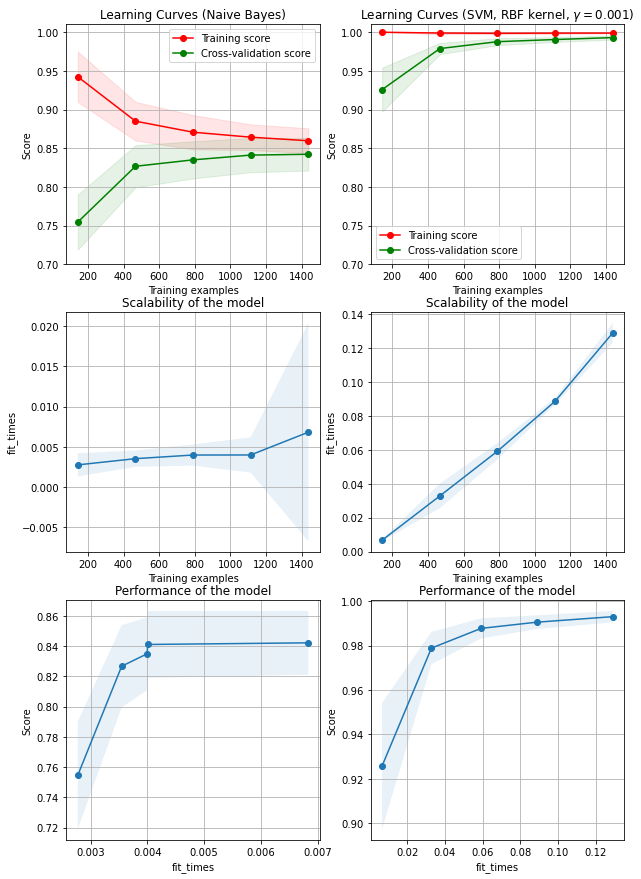

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


fig, axes = plt.subplots(3, 2, figsize=(10, 15))

X, y = load_digits(return_X_y=True)

title = "Learning Curves (Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

estimator = GaussianNB()
plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

title = r"Learning Curves (SVM, RBF kernel, $\gamma=0.001$)"
# SVC is more expensive so we do a lower number of CV iterations:
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
estimator = SVC(gamma=0.001)
plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
                    cv=cv, n_jobs=-1)

plt.show()

## imports

In [1]:
# for plotting
import matplotlib.pyplot as plt
# import scikit learn databases
from sklearn import datasets
# for exploratory data analysis vis
import seaborn as sns
# for table/data-frame manipulations
import pandas as pd


## declare some global variables

In [2]:
# how much detail we want to print
verbose = 1
plot_universal = False
location = 'california'

## Get Data: 1990s California Housing
### Predicting a house's value based on its attributes

In [3]:
# load the dataset
if location == 'california':
    dataset = datasets.fetch_california_housing()
    feedback = location.title() + ' Prediction Target: ' + dataset.target_names[0]

elif location == 'boston':
    dataset = datasets.load_boston()
    feedback = location.title() + 'Prediction Target: Median_Val'
if verbose:
    print(feedback)
    print('='*len(feedback), '\n')
    print(dataset.DESCR)

California Prediction Target: MedHouseVal

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geog

In [4]:
# put data into a df
df = pd.DataFrame(
    data = dataset.data, columns=dataset.feature_names
)
# add the target variable for exploratory data analysis
if location == 'california':
    # measured in $100,000
    df[dataset.target_names[0]] = dataset.target*100000
    # adjust the Medin Income which is measured in $10,000
    df['MedInc'] = df['MedInc']*10000
elif location == 'boston':
    df['Median_Val'] = dataset.target
# show first few rows
df.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,83252.0,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,452600.0
1,83014.0,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,358500.0
2,72574.0,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,352100.0
3,56431.0,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,341300.0
4,38462.0,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,342200.0


In [5]:
# check for nulls
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [6]:
# quick 5 stat summary
df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,38706.710029,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,206855.816909
std,18998.217179,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,115395.615874
min,4999.000000,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,14999.000000
25%,25634.000000,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,119600.000000
50%,35348.000000,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,179700.000000
75%,47432.500000,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,264725.000000
max,150001.000000,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,500001.000000


The traditional test/train split is important because during "training" the model fits to the training data

## To see why Cross Validation is important, let's begin with an extremely simplified version of the problem
- And we'll show how the model fits its parameters to the training data
- how we use validation data to score it
- and how we use test data to estimate how well the model will generalize

### Linear Regression between one feature and the target
- This is the actual relationship between our input features and our target (prediction) feature
- Let's assume this is a "God's eye" view of all the data in the universe

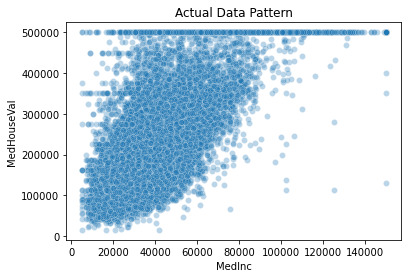

In [7]:
if location == 'california':
    # pick the median income of the house's block
    first_ft = 'MedInc'
    target = 'MedHouseVal'
fig = sns.scatterplot(
    x = df[first_ft],
    y = df[target],
    alpha = .3
)
plt.title('Actual Data Pattern')

plt.show()

### Incrementally add data to see how the linear model adapts
- Let's assume that we have limitations on how much data we can train a model on
    - maybe we don't have a lot of data
    - or maybe we have a lot but it's costly to compute on all of it

## If we don't use cross validation, we split our data in the traditional 70/30 (train/test) split and score our model's performance

In [8]:
# generate n fibonnaci steps 
n = 4
# init the sequence
fib = [1,1]
for i in range(n):
    fib.append(sum(fib[-2:]))
fib = fib[2:]
fib

[2, 3, 5, 8]

In [9]:
#plt.plot(fib, 'ro--')

## Minimum viable example of 60/20/20 3/1/1

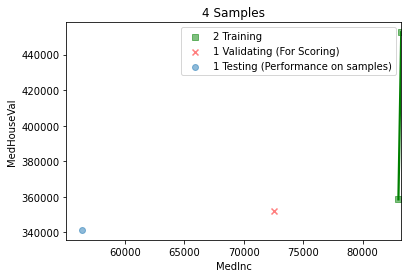

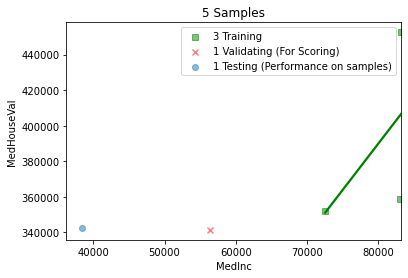

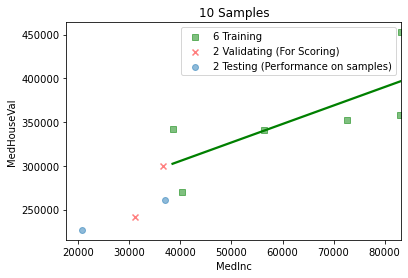

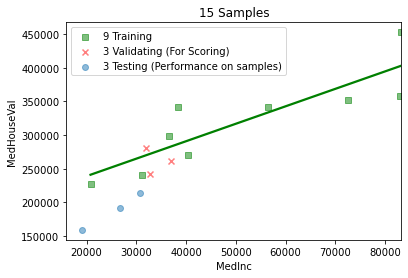

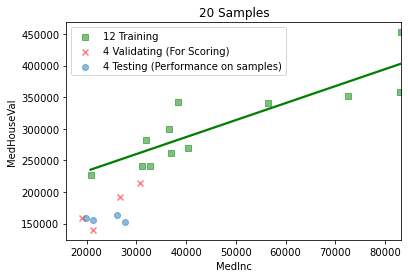

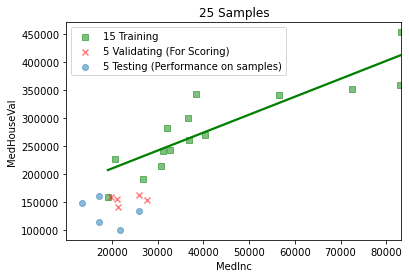

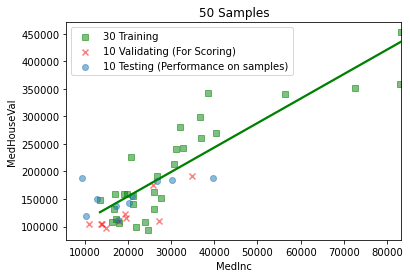

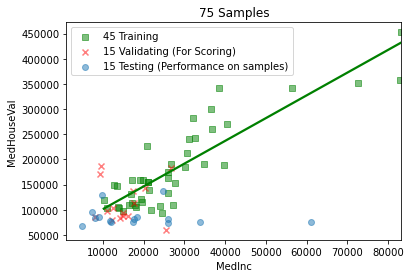

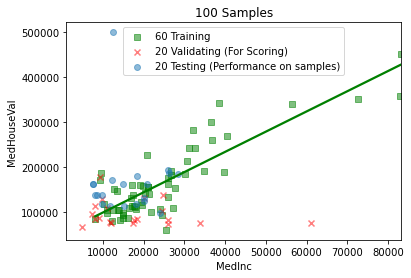

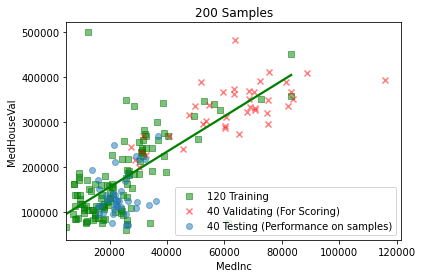

In [10]:
steps = [
    # the minimum viable split
    4,
    # increments of 5 (splittable in 60/20/20)
    5,10,15,20,25,
    # increments of 25
    50, 75, 100, 200
]

for m_samples in steps:
    # define the count of each data split
    m_train = int(m_samples*.60)
    m_validate = max([int(m_samples*.20), 1])
    m_test = max([int(m_samples*.20), 1])
    
    # plot the training data and model
    ax = sns.regplot(
        x = df[first_ft][:m_train],
        y = df[target][:m_train],
        scatter = True,
        color = 'green',
        marker = 's',
        line_kws = {'linestyle':'-'},
        scatter_kws = {'alpha': 0.5},
        # fit a regression line
        fit_reg = True,
        # order of the polynomial fit
        order = 1,
        # don't calculate the confidence interval or bootstrap samples
        ci = 0,
        n_boot = 10,
        label = f'{m_train} Training',
    )
    
    if plot_universal:
        # plot all the uninverse's data
        ax.scatter(
            x = df[first_ft][m_train + m_validate + m_test:],
            y = df[target][m_train + m_validate + m_test:],
            label = f'{m_validate} Universal Data',
            # set transparency
            alpha = .2,
            #c = 'cyan',
            #facecolors = 'blue',
            edgecolors= 'white',
        )

    # plot the validation data
    ax.scatter(
        x = df[first_ft][m_train:m_train + m_validate],
        y = df[target][m_train:m_train + m_validate],
        color = 'red',
        marker = 'x',
        # opacity
        alpha = .5,
        label = f'{m_validate} Validating (For Scoring)',
    )

    # plot the testing data
    ax.scatter(
        x = df[first_ft][m_train + m_validate:m_train + m_validate + m_test],
        y = df[target][m_train + m_validate:m_train + m_validate + m_test],
        #opacity
        alpha = .5,
        label = f'{m_validate} Testing (Performance on samples)',
    )
    
    
    
    # call the legend
    ax.legend()
    # add title 
    plt.title(f'{m_samples} Samples')
    plt.show()

## Ok, Now let's do it with actual sklearn

# Tinkering

## subplots

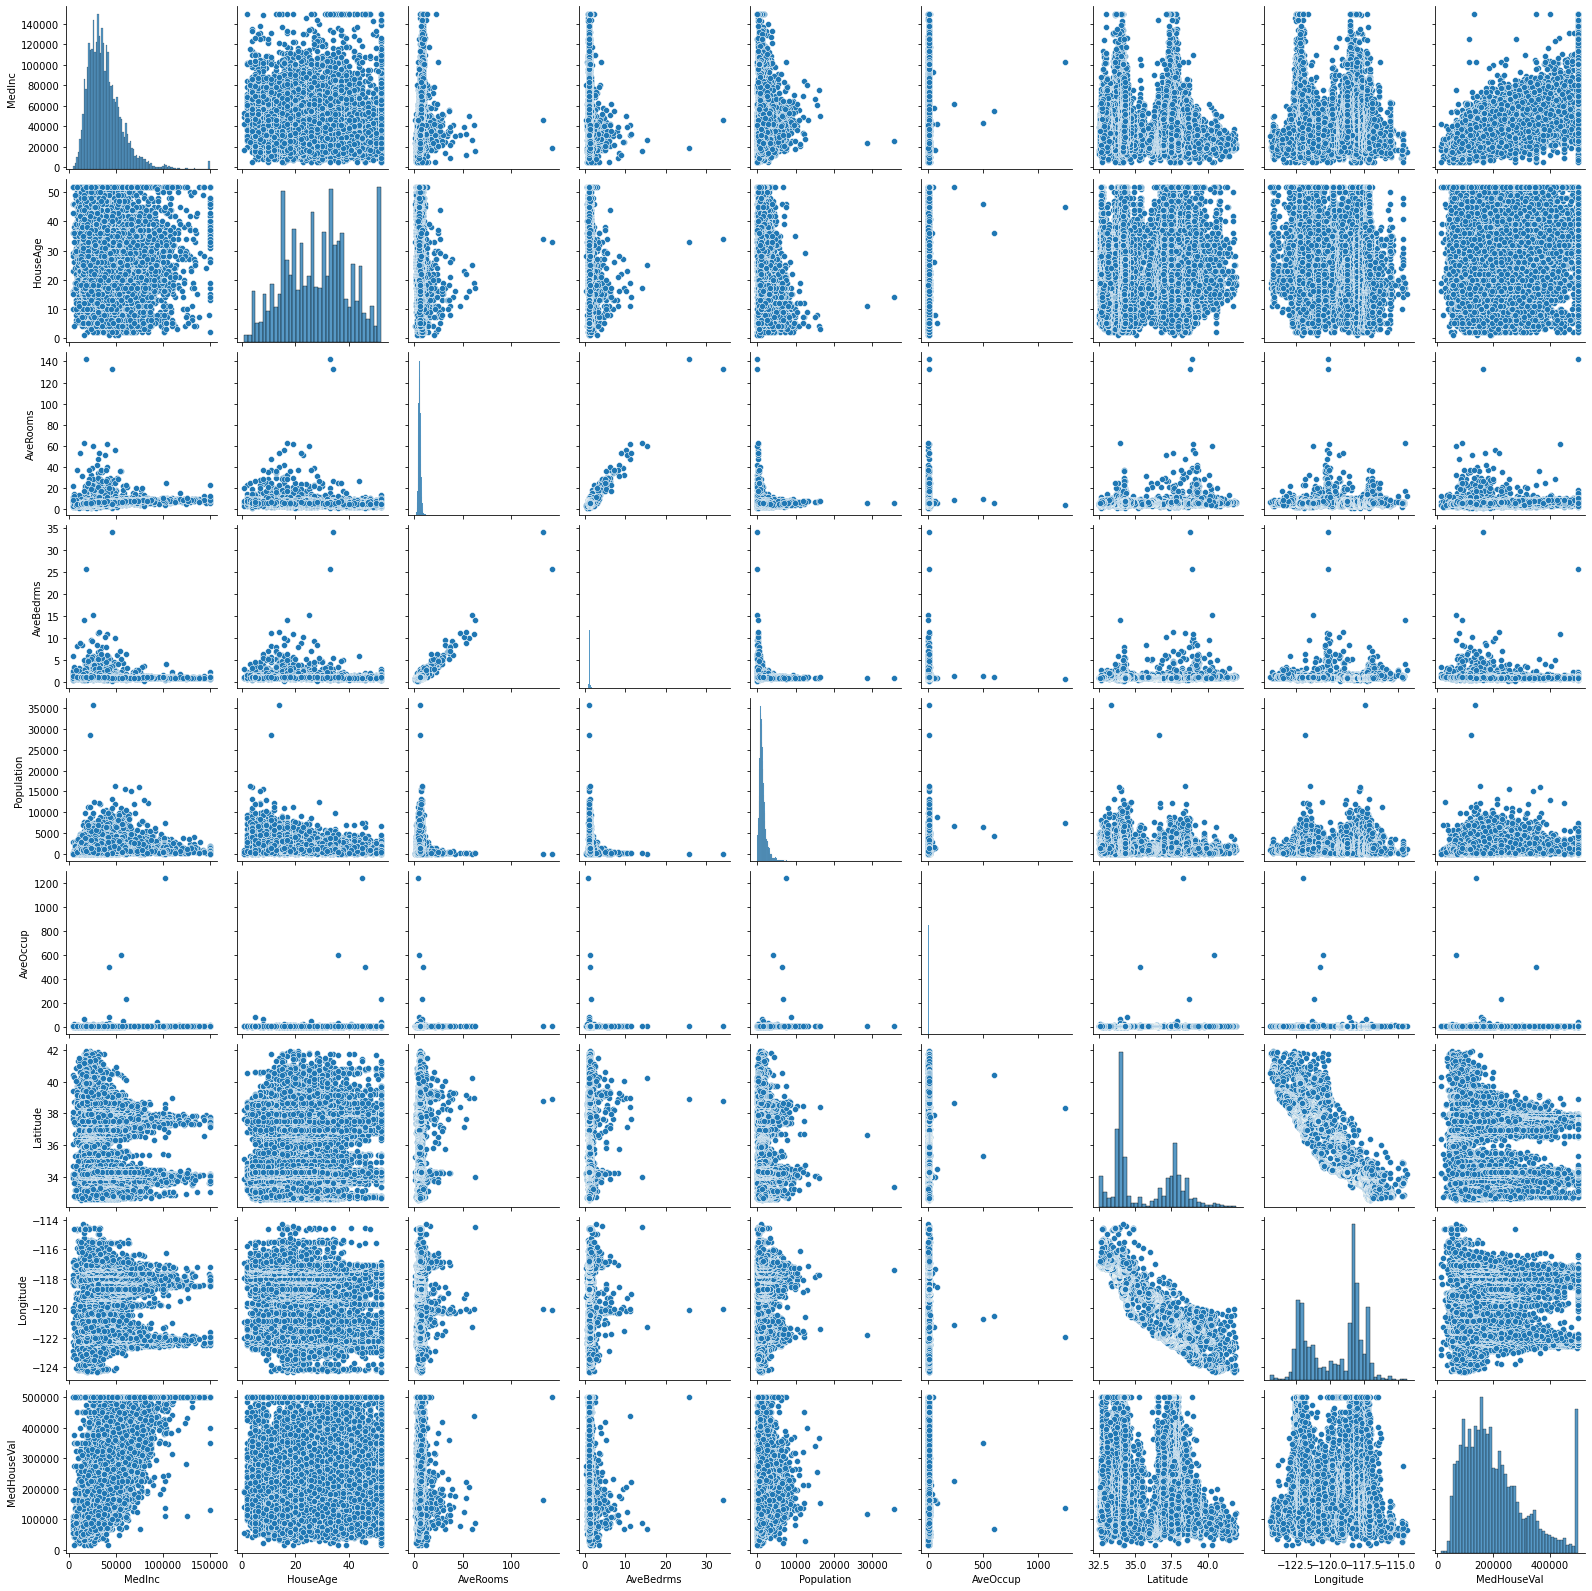

In [11]:
sns.pairplot(
    data = df,
    # plot scatters
    kind = 'scatter'
)

<AxesSubplot:>

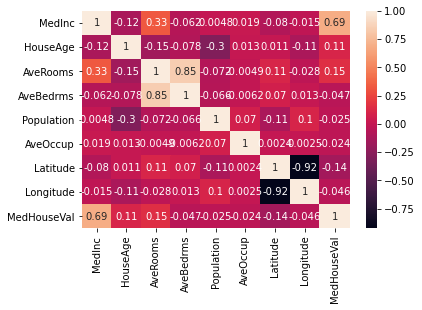

In [12]:
sns.heatmap(
    df.corr(),
    annot = True
)

# Tinkering

## Bibliography

[_Cross Validation A Beginners Guide_](https://towardsdatascience.com/cross-validation-a-beginners-guide-5b8ca04962cd), [Caleb Neale](https://www.linkedin.com/in/calebneale/), Demetri Workman, Abhinay Dommalapati
May 24, 2019, consulted 11/3/2020
- pretty good discussion of hold-out validation, K-fold CV, and Leave One Out CV (LOOCV)